# BEE 4750 Homework 3: Dissolved Oxygen and Monte Carlo

**Name**:

**ID**:

> **Due Date**
>
> Thursday, 10/03/23, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to implement a model for dissolved oxygen in a
    river with multiple waste releases and use this to develop a
    strategy to ensure regulatory compliance.
-   Problem 2 asks you to use Monte Carlo simulation to assess how well
    your strategy from Problem 1 performs under uncertainty.
-   Problem 3 (5750 only) asks you to identify where a third discharge
    should be placed to maintain regulatory compliance.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [4]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
Pkg.add("DifferentialEquations")

  Activating project at `c:\Users\noah\labs\hw3-nhartman-test`
    Updating registry at `C:\Users\noah\.julia\registries\General.toml`
   Resolving package versions...
   Installed Accessors ─────────────────────────── v0.1.38
   Installed DifferentialEquations ─────────────── v7.14.0
   Installed OrdinaryDiffEqSDIRK ───────────────── v1.1.0
   Installed OrdinaryDiffEqRKN ─────────────────── v1.1.0
   Installed OrdinaryDiffEqRosenbrock ──────────── v1.2.0
   Installed OffsetArrays ──────────────────────── v1.14.1
   Installed OrdinaryDiffEqStabilizedRK ────────── v1.1.0
   Installed TimerOutputs ──────────────────────── v0.5.24
   Installed NonlinearSolve ────────────────────── v3.14.0
   Installed StaticArrays ──────────────────────── v1.9.7
   Installed OrdinaryDiffEqPRK ─────────────────── v1.1.0
   Installed EnumX ─────────────────────────────── v1.0.4
   Installed Sundials_jll ──────────────────────── v5.2.2+0
   Installed Polyester ─────────────────────────── v0.7.16
   Installed

In [2]:
using Random
using Plots
using LaTeXStrings
using Distributions
using CSV
using DataFrames

In [3]:
using DifferentialEquations

## Problems (Total: 50/60 Points)

### Problem 1 (30 points)

A river which flows at 6 km/d is receiving waste discharges from two
sources which are 15 km apart. The oxygen reaeration rate is 0.55
day<sup>-1</sup>, and the decay rates of CBOD and NBOD are are 0.35 and
0.25 day<sup>-1</sup>, respectively. The river’s saturated dissolved
oxygen concentration is 10m g/L.

If the characteristics of the river inflow and waste discharges are
given in <a href="#tbl-river" class="quarto-xref">Table 1</a>, write a
Julia model to compute the dissolved oxygen concentration from the first
wastewater discharge to an arbitrary distance `d` km downstream. Use
your model to compute the maximum dissolved oxygen concentration up to
50km downstream and how far downriver this maximum occurs.

| Parameter | River Inflow | Waste Stream 1 | Waste Stream 2 |
|:--:|---:|---:|---:|
| Inflow | 100,000 m<sup>3</sup>/d | 10,000 m<sup>3</sup>/d | 15,000 m<sup>3</sup>/d |
| DO Concentration | 7.5 mg/L | 5 mg/L | 5 mg/L |
| CBOD | 5 mg/L | 50 mg/L | 45 mg/L |
| NBOD | 5 mg/L | 35 mg/L | 35 mg/L |

Table 1: River inflow and waste stream characteristics for Problem 1.

**In this problem**:

-   Plot the dissolved oxygen concentration from the first waste stream
    to 50m downriver. What is the minimum value in mg/L?
-   What is the minimum level of treatment (% removal of organic waste)
    for waste stream 1 that will ensure that the dissolved oxygen
    concentration never drops below 4 mg/L, assuming that waste stream 2
    remains untreated? How about if only waste stream 2 is treated?
-   Suppose you are responsible for designing a waste treatment plan for
    discharges into the river, with a regulatory mandate to keep the
    dissolved oxygen concentration above 4 mg/L. Discuss whether you’d
    opt to treat waste stream 2 alone or both waste streams equally.
    What other information might you need to make a conclusion, if any?

**[Write-Up]**

to start, i took the data given in the table and stored them as variables across various points across the waste stream. from there, i used the oxygen sag equation (streeter-phelps eqn), which involves the installation of the 'DifferentialEquations' package. the oxygen sag equation itself is D = (kd/(ko-kd))*Do*(e^(-kd/v*x)-e^(-ko/v*x))-(Do-D0)*e^(-ko/v*x), where D is the oxygen deficit at a certain point downstream, kd is the deoxygenation rate constant (CBOD), ko is the reaeration rate constant (NBOD), Do is the initial oxygen deficit, D0 is the initial oxygen deficit at the point of discharge, v is the stream velocity, and x is the distance downstream from the discharge point. 

from there, i made a function to use streeter-phelps equation to calculate the oxygen deficit both before and after stream 2, the summed the NBOD and COD to find the total dissolved oxygen

the plot of DO concentration is shown below. the minimum dissolved oxygen from the first waste stream to 50m downriver is: -34.35 mg/L at 22.5km downstream. 

(WRITE-UP EXPLAINS THE CODE SHOWN BELOW)

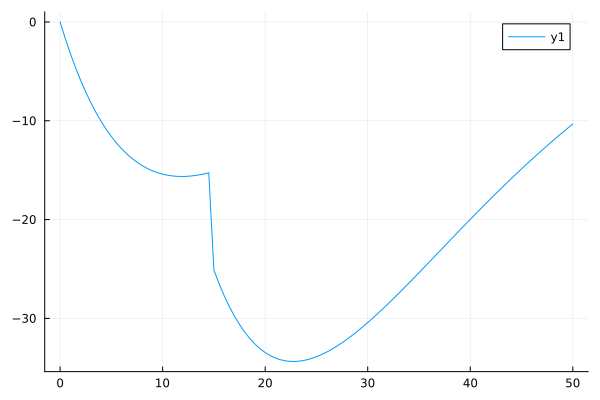

The minimum DO concentration is -34.359010069945356 mg/L at 22.5 km downstream.


In [6]:
using Plots

# given constants
u = 6.0 # river flow velocity (km/day)
K_r = 0.55 # reaeration rate (day^-1)
K_d_cbod = 0.35 # CBOD decay rate (day^-1)
K_d_nbod = 0.25 # NBOD decay rate (day^-1)
DO_sat = 10.0 # saturated DO conc (mg/L)

# stream 1 data
L0_cbod_1 = 50.0 # initial CBOD at stream 1 (mg/L)
L0_nbod_1 = 35.0 # initial NBOD at stream 1 (mg/L)
DO0_1 = 5.0 # DO concentration at stream 1 (mg/L)
D0_1 = DO_sat - DO0_1 # initial oxygen deficit for stream 1

# stream 2 data
distance_waste2 = 15.0 # km downstream
L0_cbod_2 = 45.0 # initial CBOD at stream 2 (mg/L)
L0_nbod_2 = 35.0 # initial NBOD at stream 2 (mg/L)
DO0_2 = 5.0 # DO concentration at stream 2 (mg/L)
D0_2 = DO_sat - DO0_2 # initial oxygen deficit for stream 2

# oxygen sag deficit equation (streeter-phelps) DifferentialEquations package required!
function oxygen_deficit(x, L0, D0, K_d)
    deficit = (K_d * L0) / (K_r - K_d) * (exp(-K_d * x / u) - exp(-K_r * x / u)) + D0 * exp(-K_r * x / u)
    return deficit
end

# function to compute DO concentration downstream
function DO_concentration_combined(x, L0_cbod_1, L0_nbod_1, D0_1, L0_cbod_2, L0_nbod_2, D0_2)
    if x < distance_waste2
        # since before stream 2, use only stream 1 characteristics
        D_cbod = oxygen_deficit(x, L0_cbod_1, D0_1, K_d_cbod)
        D_nbod = oxygen_deficit(x, L0_nbod_1, D0_1, K_d_nbod)
    else
        # now after stream 2, include both streams
        D_cbod_1 = oxygen_deficit(x, L0_cbod_1, D0_1, K_d_cbod)
        D_nbod_1 = oxygen_deficit(x, L0_nbod_1, D0_1, K_d_nbod)
        D_cbod_2 = oxygen_deficit(x - distance_waste2, L0_cbod_2, D0_2, K_d_cbod)
        D_nbod_2 = oxygen_deficit(x - distance_waste2, L0_nbod_2, D0_2, K_d_nbod)
        D_cbod = D_cbod_1 + D_cbod_2
        D_nbod = D_nbod_1 + D_nbod_2
    end
    
    # total DO concentration
    DO_conc = DO_sat - (D_cbod + D_nbod)
    return DO_conc
end

# compute DO concentrations from 0-50km
distances = 0:0.5:50.0
DO_concentrations = [DO_concentration_combined(x, L0_cbod_1, L0_nbod_1, D0_1, L0_cbod_2, L0_nbod_2, D0_2) for x in distances]

# plot DO concentrations
plot(distances, DO_concentrations, xlabel="Distance downstream (km)", ylabel="Dissolved Oxygen (mg/L)", title="DO Concentration from Waste Stream 1 to 50 km", lw=2)

# minimum DO concentration
minimum_DO = minimum(DO_concentrations)
min_DO_distance = distances[argmin(DO_concentrations)]
println("The minimum DO concentration is $minimum_DO mg/L at $min_DO_distance km downstream.")

plot(distances, DO_concentrations, xlabel="Distance downstream (km)", ylabel="Dissolved Oxygen (mg/L)", title="DO Concentration from Waste Stream 1 to 50 km", lw=2)
display(plot(distances, DO_concentrations))



[**Write-Up]**

the next section of code (shown below) calculates the minimum level of treatment for waste stream 1 that will ensure that the dissolved oxygen concentration never drops below 4 mg/L, assuming that waste stream 2 remains untreated it additionally calculates the minimum level of treatment if only waste stream 2 is treated.

to start, the treatment level for stream 1 was calculated by determining the removal percentage by summing the amount of COD and NBOD treated and subtracting it from the intial amount of COD and NBOD that had originally entered the system. from there, a function was added to check whether or not the DO concentration meets or exceeds the threshold of 4mg/L.

this code essentially repeats itself again, but this time using the parameters for stream 2. 

both functions state that a threshold percentage could not be found, which suggests that the model is unable to find a level of treatment (a percentage reduction in CBOD and NBOD from waste stream 1) that can ensure the dissolved oxygen (DO) concentration stays above the target of 4 mg/L. possible reasons to explain this is; the pollution load being too high, additional downstream factors impacting the system, or upstream inflow contribution.

(THIS WRITE UP EXPLAINS THE CODE SHOWN BELOW)

In [7]:
# function to compute treatment level needed for waste stream 1
function min_treatment_waste1(target_DO::Float64)
    for removal_percent in 0:0.01:1.0
        # apply percentage removal to Waste Stream 1
        L0_cbod_1_treated = L0_cbod_1 * (1.0 - removal_percent)
        L0_nbod_1_treated = L0_nbod_1 * (1.0 - removal_percent)

        # recompute DO concentrations with treated waste stream 1
        DO_concentrations = [DO_concentration_combined(x, L0_cbod_1_treated, L0_nbod_1_treated, D0_1, L0_cbod_2, L0_nbod_2, D0_2) for x in distances]

        # if DO stays above target, return the treatment percentage
        if minimum(DO_concentrations) >= target_DO
            return removal_percent * 100
        end
    end
    return "Treatment level could not be found."
end

# function to compute treatment level needed for waste stream 2
function min_treatment_waste2(target_DO::Float64)
    for removal_percent in 0:0.01:1.0
        # apply percentage removal to Waste Stream 2
        L0_cbod_2_treated = L0_cbod_2 * (1.0 - removal_percent)
        L0_nbod_2_treated = L0_nbod_2 * (1.0 - removal_percent)

        # recompute DO concentrations with treated waste stream 2
        DO_concentrations = [DO_concentration_combined(x, L0_cbod_1, L0_nbod_1, D0_1, L0_cbod_2_treated, L0_nbod_2_treated, D0_2) for x in distances]

        # if DO stays above target, return the treatment percentage
        if minimum(DO_concentrations) >= target_DO
            return removal_percent * 100
        end
    end
    return "Treatment level could not be found."
end

# calculate the minimum treatment percentage for stream 1
min_treatment_percent_1 = min_treatment_waste1(4.0)
println("Minimum treatment for Waste Stream 1 to maintain DO ≥ 4 mg/L: $min_treatment_percent_1")

# calculate the minimum treatment percentage for stream 2
min_treatment_percent_2 = min_treatment_waste2(4.0)
println("Minimum treatment for Waste Stream 2 to maintain DO ≥ 4 mg/L: $min_treatment_percent_2")


Minimum treatment for Waste Stream 1 to maintain DO ≥ 4 mg/L: Treatment level could not be found.
Minimum treatment for Waste Stream 2 to maintain DO ≥ 4 mg/L: Treatment level could not be found.


**[Write-Up]**
I would opt to treat only stream 2  since it enters the river further downstream and has a higher flow rate. treating this stream alone may allow the DO levels in the section of the river most likely to experience oxygen depletion to increase.  additional information to make the best conclusion possible include; treatment costs, relative contributions of COD and NBOD, natural reaeration capacity at the site, and or seasonal/environmental impacts and factors.

Another possible reason as to why the code is unable to produce solutions that would allow for the minimum treatment for streams 1 and 2 to maintain a dissolved oxygen concentration of >= 4mg/L could be the fact that the streeter-phelps equation i used to determine the oxygen sag is a differential equation, meaning solutions for the minimum waste treatment could be non-zero, which would fail to satisfy the condition of waste treated being greater than or equal to 4mg/L

### Problem 2 (20 points)

The simplest climate model involves capturing changes to the Earth’s
energy budget (it is commonly called the *energy balance model*, or
EBM). These changes are also called *radiative forcings* (RF), and can
result from several causes, including greenhouse gas emissions, volcanic
eruptions, and changes to the solar cycle. The EBM treats the Earth as a
0-dimensional sphere covered with water, which absorbs heat in response
to radiative forcings. Chanwith global temperature changes resulting
from imbalances in the average (over the entire surface area) heat flux.

The EBM equations are:

$$
\begin{align*}
\overbrace{\frac{dH}{dt}}^{\text{change in heat}} &= \overbrace{F}^{\substack{\text{radiative} \\ \text{forcing}}} - \overbrace{\lambda T}^{\substack{\text{change in} \\ \text{temperature}}} \\
\underbrace{C}_{\substack{\text{ocean heat} \\ \text{capacity}}} \frac{dT}{dt} &= F - \lambda T \\
c\underbrace{d}_{\substack{\text{ocean} \\ \text{mixing depth}}} \frac{dT}{dt} &= F - \lambda T,
\end{align*}
$$

where $c = 4.184\times 10^6 \mathrm{J/K/m}^2$ is the specific heat of
water per area, $d$ is the depth of the ocean mixed layer (we’ll assume
$d = 86 \mathrm{m}$), and $\lambda$ is the **climate feedback factor**
and controls how much the Earth warms in response to increased radiative
forcing (assume
$\lambda = 2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2$)). The total
radiative forcing $F = F_\text{non-aerosol} + \alpha F_\text{aerosol}$,
where $\alpha$ is an uncertain scaling factor reflecting aerosol-cloud
feedbacks (we’ll assume $\alpha = 0.8$).

The code below loads historical and projected radiative forcings (under
the SSP5-8.5 future emissions scenario, which is the most extreme of the
scenarios used to project climate change impacts) from
`data/ERF_ssp585_1750-2500.csv` into a `DataFrame` object and calculates
the non-aerosol and aerosol components of those forcings.

> **Tip**
>
> Look closely at and experiment with the code below: `DataFrames` are a
> common Julia datatype for tabular data, and you may work more with
> them later in the semester or beyond! They are broadly similar to
> `DataFrames` from `pandas` in Python.

In [1]:
# Dataset from https://zenodo.org/record/3973015
# The CSV is read into a DataFrame object, and we specify that it is comma delimited
forcings_all = CSV.read("data/ERF_ssp585_1750-2500.csv", DataFrame, delim=",")

# Separate out the individual components
# Get total aerosol forcings
forcing_aerosol_rad = forcings_all[!,"aerosol-radiation_interactions"]
forcing_aerosol_cloud = forcings_all[!,"aerosol-cloud_interactions"]
forcing_aerosol = forcing_aerosol_rad + forcing_aerosol_cloud
# Calculate non-aerosol forcings from the total.
forcing_total = forcings_all[!,"total"]
forcing_non_aerosol = forcing_total - forcing_aerosol

We can plot the aerosol and non-aerosol forcings below.

In [1]:
t = Int64.(forcings_all[!,"year"]) # Ensure that years are interpreted as integers
p_forcing = plot(; xlabel="Year", ylabel="Radiative Forcing (W/m²)")
plot!(p_forcing, t, forcing_aerosol, label="Aerosol Forcing", color=:blue, linewidth=2)
plot!(p_forcing, t, forcing_non_aerosol, label="Non-Aerosol Forcing", color=:red, linewidth=2)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path clip-path="url(#clip100)" d="M463.247 1782.41 Q459.914 1782.41 457.992 1784.19 Q456.094 1785.97 456.094 1789.1 Q456.094 1792.22 457.992 1794.01 Q459.914 1795.79 463.247 1795.79 Q466.58 1795.79 468.501 1794.01 Q470.423 1792.2 470.423 1789.1 Q470.423 1785.97 468.501 1784.19 Q466.603 1782.41 463.247 1782.41 M458.571 1780.42 Q455.562 1779.68 453.872 1777.62 Q452.205 1775.56 452.205 1772.59 Q452.205 1768.45 455.145 1766.04 Q458.108 1763.64 463.247 1763.64 Q468.409 1763.64 471.349 1766.04 Q474.288 1768.45 474.288 1772.59 Q474.288 1775.56 472.599 1777.62 Q470.932 1779.68 467.946 1780.42 Q471.326 1781.21 473.201 1783.5 Q475.099 1785.79 475.099 1789.1 Q475.099 1794.12 472.02 1796.81 Q468.964 1799.49 463.247 1799.49 Q457.529 1799.49 454.451 1796.81 Q451.395 1794.12 451.395 1789.1 Q451.395 1785.79 453.293 1783.5 Q455.191 1781.21 458.571 1780.42 M456.858 1773.03 Q456.858 1775.72 458.525 1777.22 Q460.214 1778.73 463.247 1778.73 Q466.256 1778.73 467.946 1777.22 Q469.659 1775.72 469.659 1773.03 Q469.659 1770.35 467.946 1768.84 Q466.256 1767.34 463.247 1767.34 Q460.214 1767.34 458.525 1768.84 Q456.858 1770.35 456.858 1773.03 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip100)" d="M493.409 1767.34 Q489.798 1767.34 487.969 1770.9 Q486.163 1774.45 486.163 1781.58 Q486.163 1788.68 487.969 1792.25 Q489.798 1795.79 493.409 1795.79 Q497.043 1795.79 498.849 1792.25 Q500.677 1788.68 500.677 1781.58 Q500.677 1774.45 498.849 1770.9 Q497.043 1767.34 493.409 1767.34 M493.409 1763.64 Q499.219 1763.64 502.274 1768.24 Q505.353 1772.83 505.353 1781.58 Q505.353 1790.3 502.274 1794.91 Q499.219 1799.49 493.409 1799.49 Q487.599 1799.49 484.52 1794.91 Q481.464 1790.3 481.464 1781.58 Q481.464 1772.83 484.52 1768.24 Q487.599 1763.64 493.409 1763.64 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip100)" d="M523.571 1767.34 Q519.96 1767.34 518.131 1770.9 Q516.325 1774.45 516.325 1781.58 Q516.325 1788.68 518.131 1792.25 Q519.96 1795.79 523.571 1795.79 Q527.205 1795.79 529.01 1792.25 Q530.839 1788.68 530.839 1781.58 Q530.839 1774.45 529.01 1770.9 Q527.205 1767.34 523.571 1767.34 M523.571 1763.64 Q529.381 1763.64 532.436 1768.24 Q535.515 1772.83 535.515 1781.58 Q535.515 1790.3 532.436 1794.91 Q529.381 1799.49 523.571 1799.49 Q517.76 1799.49 514.682 1794.91 Q511.626 1790.3 511.626 1781.58 Q511.626 1772.83 514.682 1768.24 Q517.76 1763.64 523.571 1763.64 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip100)" d="M1026.29 1794.89 L1042.61 1794.89 L1042.61 1798.82 L1020.66 1798.82 L1020.66 1794.89 Q1023.33 1792.13 1027.91 1787.5 Q1032.52 1782.85 1033.7 1781.51 Q1035.94 1778.98 1036.82 1777.25 Q1037.72 1775.49 1037.72 1773.8 Q1037.72 1771.04 1035.78 1769.31 Q1033.86 1767.57 1030.76 1767.57 Q1028.56 1767.57 1026.1 1768.34 Q1023.67 1769.1 1020.9 1770.65 L1020.9 1765.93 Q1023.72 1764.79 1026.17 1764.21 Q1028.63 1763.64 1030.66 1763.64 Q1036.03 1763.64 1039.23 1766.32 Q1042.42 1769.01 1042.42 1773.5 Q1042.42 1775.63 1041.61 1777.55 Q1040.83 1779.45 1038.72 1782.04 Q1038.14 1782.71 1035.04 1785.93 Q1031.94 1789.12 1026.29 1794.89 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip100)" d="M1062.42 1767.34 Q1058.81 1767.34 1056.98 1770.9 Q1055.18 1774.45 1055.18 1781.58 Q1055.18 1788.68 1056.98 1792.25 Q1058.81 1795.79 1062.42 1795.79 Q1066.06 1795.79 1067.86 1792.25 Q1069.69 1788.68 1069.69 1781.58 Q1069.69 1774.45 1067.86 1770.9 Q1066.06 1767.34 1062.42 1767.34 M1062.42 1763.64 Q1068.23 1763.64 1071.29 1768.24 Q1074.37 1772.83 1074.37 1781.58 Q1074.37 1790.3 1071.29 1794.91 Q1068.23 1799.49 1062.42 1799.49 Q1056.61 1799.49 1053.53 1794.91 Q1050.48 1790.3 1050.48 1781.58 Q1050.48 1772.83 1053.53 1768.24 Q1056.61 1763.64 1062.42 1763.64 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip100)" d="M1092.58 1767.34 Q1088.97

**In this problem**:

-   Discretize the EBM to produce a simulation model of global mean
    temperatures $T$ over time as a result of total radiative forcings
    $F$.

-   Simulate global mean temperature anomalies (in $^\circ C$ relative
    to 1750) from your model using the historical and SSP5-8.5 radiative
    forcing data. Use an annual time step for the simulation (in
    seconds: $\Delta t = 31,558,152 \mathrm{s}$). You can assume
    $T(0) = 0^\circ C$. Plot the resulting temperature simulation.

-   The climate feedback factor $\lambda$ is one of the key
    uncertainties in projecting future temperatures, even assuming a
    particular scenario of future radiative forcing. Suppose we use the
    following distribution for $\lambda$,
    $$\lambda \sim \text{LogNormal}(\log(2.1), \log(2)/4).$$

    Use Monte Carlo simulation to estimate the expected temperature in
    2100 assuming SSP5-RCP 8.5 radiative forcings (with 95% confidence
    intervals). How does this estimate compare to the value you got from
    your simulation using the expected value of
    $\lambda=2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2)$? How did
    you decide your sample set was sufficient?

**[Write-Up]** 

"Discretize the EBM to produce a simulation model of global mean temperatures $T$ over time as a result of total radiative forcings $F$."

to start, i first took the given data and created variables for constants (specific heat, ocean mixed layer depth, climate feedback factor, ocean heat capacity). from there, i simulated the time from 1750 to 2500 with a time step of 1 year increments. from there, a loop was created using the discretized EBM equation "T[t]= T[t-1] + (delta_t / C) * (F_total)[t-1] - lambda * T[t-1]". from there, the results were plotted and are presented in the code below

**this write up explains the code shown below**

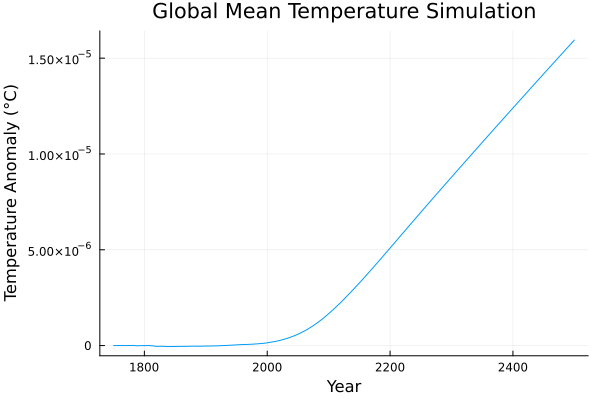

In [1]:
using CSV, DataFrames, Plots

# given constants
c = 4.184e6  # Specific heat of water per unit area [J/K/m^2]
d = 86.0     # Ocean mixing depth [m]
lambda = 2.1      # Climate feedback factor [deg C/(W/m^2)]
C = c * d    # Ocean heat capacity [J/K/m^2]

# time steps + simulation period
delta_t = 1.0  # time step in years
n_years = 2500 - 1750  # simulation period from year 1750 to 2500

# initial conditions
T0 = 0.0  # initial temperature anomaly [deg C]
time = 1750:delta_t:2500  # time vector

# load radiative forcing data
forcings_all = CSV.read("data/ERF_ssp585_1750-2500.csv", DataFrame, delim=",")

# extract total radiative forcing F(t)
F_total = forcings_all[!,"total"]

# initialize temperature array
T = zeros(length(time))
T[1] = T0

# simulation loop for each time step
for t in 2:length(time)
    # apply the discretized EBM equation
    T[t] = T[t-1] + (delta_t / C) * (F_total[t-1] - lambda * T[t-1])
end

# plot the result
plot(time, T, xlabel="Year", ylabel="Temperature Anomaly (°C)", title="Global Mean Temperature Simulation", legend=false)


**[Write-Up]**

"Simulate global mean temperature anomalies (in $^\circ C$ relative
    to 1750) from your model using the historical and SSP5-8.5 radiative
    forcing data. Use an annual time step for the simulation (in
    seconds: $\Delta t = 31,558,152 \mathrm{s}$). You can assume
    $T(0) = 0^\circ C$. Plot the resulting temperature simulation."

this problem is very similar to the one above, however the radiative forcing data is extracted from the SSP5-8.5 dataset provided to us. additionally, the EBM loop outputs the temperature anomalies in units of seconds, not years (the previous code above expresses outputs in years). lastly, the plot of the global mean temperature relative to 1750 for the years 1750 - 2500 is shown below.

**this write up explains the code shown below**

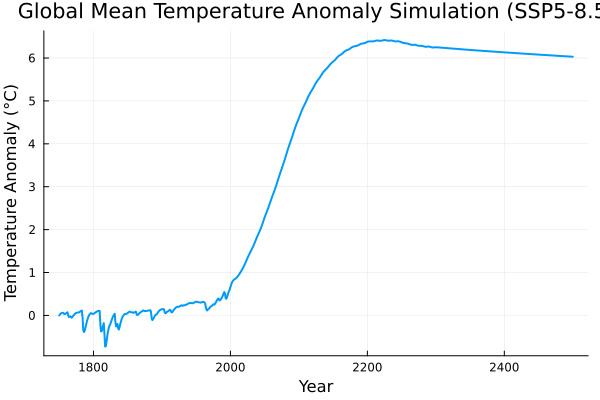

In [2]:
using CSV, DataFrames, Plots

# Constants
c = 4.184e6  # Specific heat of water per unit area [J/K/m²]
d = 86.0     # Ocean mixing depth [m]
λ = 2.1      # Climate feedback factor [°C/(W/m²)]
C = c * d    # Ocean heat capacity [J/K/m²]
Δt_seconds = 31_558_152.0  # Time step in seconds (1 year in seconds)

# Initial conditions
T0 = 0.0  # Initial temperature anomaly [°C]
years = 1750:2500  # Years of simulation

# Load radiative forcing data
forcings_all = CSV.read("data/ERF_ssp585_1750-2500.csv", DataFrame, delim=",")

# Extract total radiative forcing F(t)
F_total = forcings_all[!,"total"]

# Initialize temperature array
T = zeros(length(years))
T[1] = T0

# Simulation loop for each time step (year)
for t in 2:length(years)
    # Apply the discretized EBM equation with time step in seconds
    T[t] = T[t-1] + (Δt_seconds / C) * (F_total[t-1] - λ * T[t-1])
end

# Plot the result
plot(years, T, xlabel="Year", ylabel="Temperature Anomaly (°C)", 
    title="Global Mean Temperature Anomaly Simulation (SSP5-8.5)", 
    legend=false, lw=2, grid=true)


**[Write-Up]**

to start, i defined the log normal distribution for lambda, lamba = LogNormal(log(2.1), log(2)/4). from there, the code runs a MCA (monte carlo analysis) for each sample of lambda to simulate the global temperature anomaly in the year 2100 based on the SSP5-8.5 radiative forcing data. Next, the resulting temperature anomalies were used to calculate the 95% confidence intervals (2.5th and 97.5th percentiles). lastly, the data was compared to lambda of the previously computed temperatures and a plot was created.

Expected temperature in 2100 (Monte Carlo): 4.663 °C
95% Confidence Interval: [[3.334, 6.337][1], [3.334, 6.337][2]] °C
Deterministic temperature in 2100 (λ = 2.1): 4.6 °C


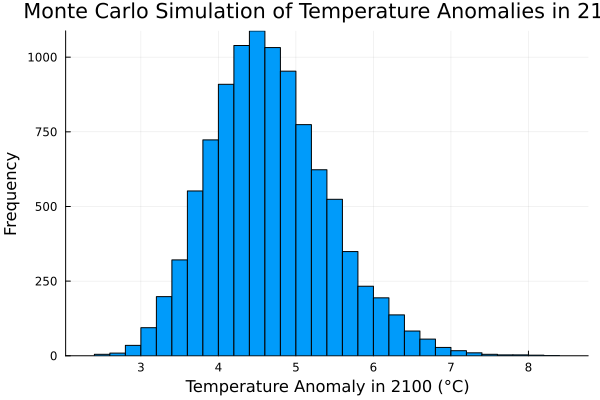

In [4]:
using CSV, DataFrames, Distributions, Statistics, Plots

# Constants
c = 4.184e6  # Specific heat of water per unit area [J/K/m²]
d = 86.0     # Ocean mixing depth [m]
C = c * d    # Ocean heat capacity [J/K/m²]
Δt_seconds = 31_558_152.0  # Time step in seconds (1 year in seconds)

# Initial conditions
T0 = 0.0  # Initial temperature anomaly [°C]
years = 1750:2500  # Years of simulation

# Load radiative forcing data
forcings_all = CSV.read("data/ERF_ssp585_1750-2500.csv", DataFrame, delim=",")
F_total = forcings_all[!,"total"]

# Monte Carlo parameters
n_simulations = 10_000  # Number of Monte Carlo simulations
λ_dist = LogNormal(log(2.1), log(2) / 4)  # LogNormal distribution for λ
year_2100_index = findfirst(==(2100), years)  # Index of the year 2100

# Function to simulate temperature for a given λ
function simulate_temperature(λ)
    T = zeros(length(years))
    T[1] = T0
    
    for t in 2:length(years)
        T[t] = T[t-1] + (Δt_seconds / C) * (F_total[t-1] - λ * T[t-1])
    end
    return T[year_2100_index]
end

# Run Monte Carlo simulations
T_2100_samples = [simulate_temperature(rand(λ_dist)) for _ in 1:n_simulations]

# Calculate expected value and 95% confidence interval
T_2100_mean = round(mean(T_2100_samples), digits=3)
T_2100_ci = round.(quantile(T_2100_samples, [0.025, 0.975]), digits=3)

# Deterministic simulation with λ = 2.1
λ_expected = 2.1
T_deterministic = round(simulate_temperature(λ_expected), digits=3)

# Output the results
println("Expected temperature in 2100 (Monte Carlo): $T_2100_mean °C")
println("95% Confidence Interval: [$T_2100_ci[1], $T_2100_ci[2]] °C")
println("Deterministic temperature in 2100 (λ = 2.1): $T_deterministic °C")

# Plot histogram of Monte Carlo results
histogram(T_2100_samples, bins=50, xlabel="Temperature Anomaly in 2100 (°C)", 
          ylabel="Frequency", title="Monte Carlo Simulation of Temperature Anomalies in 2100",
          legend=false)


### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

A factory is planning a third wastewater discharge into the river
downstream of the second plant. This discharge would consist of 5
m<sup>3</sup>/day of wastewater with a dissolved oxygen content of 4.5
mg/L and CBOD and NBOD levels of 50 and 45 mg/L, respectively.

**In this problem**:

-   Assume that the treatment plan you identified in Problem 1 is still
    in place for the existing discharges. If the third discharge will
    not be treated, under the original inflow conditions (7.5 mg/L DO),
    how far downstream from the second discharge does this third
    discharge need to be placed to keep the river concentration from
    dropping below 4 mg/L?

**[Write-Up]**

to start, the model now iterates through potential distances downstream for the third discharge, starting at the location of the second discharge and going up to 50 km downstream. If a valid distance is not found within the range of 0 to 50 km, the output will state that no feasible distance was found and suggest treating the third discharge or extending the range further downstream. For each possible location of the third discharge, the code checks if the minimum dissolved oxygen concentration stays above 4 mg/L at all downstream points. If it does, that distance is returned. 

**this code explains the code shown below**

In [9]:
# Function to compute DO concentration with three discharges
function DO_concentration_three_discharge(x, L0_cbod_1, L0_nbod_1, D0_1, L0_cbod_2, L0_nbod_2, D0_2, L0_cbod_3, L0_nbod_3, D0_3, x3)
    if x < distance_waste2
        # Before Waste Stream 2, use only Stream 1 characteristics
        D_cbod = oxygen_deficit(x, L0_cbod_1, D0_1, K_d_cbod)
        D_nbod = oxygen_deficit(x, L0_nbod_1, D0_1, K_d_nbod)
    elseif x < x3
        # After Waste Stream 1 but before Waste Stream 3, include Stream 2
        D_cbod_1 = oxygen_deficit(x, L0_cbod_1, D0_1, K_d_cbod)
        D_nbod_1 = oxygen_deficit(x, L0_nbod_1, D0_1, K_d_nbod)
        D_cbod_2 = oxygen_deficit(x - distance_waste2, L0_cbod_2, D0_2, K_d_cbod)
        D_nbod_2 = oxygen_deficit(x - distance_waste2, L0_nbod_2, D0_2, K_d_nbod)
        D_cbod = D_cbod_1 + D_cbod_2
        D_nbod = D_nbod_1 + D_nbod_2
    else
        # After Waste Stream 3, include all three streams
        D_cbod_1 = oxygen_deficit(x, L0_cbod_1, D0_1, K_d_cbod)
        D_nbod_1 = oxygen_deficit(x, L0_nbod_1, D0_1, K_d_nbod)
        D_cbod_2 = oxygen_deficit(x - distance_waste2, L0_cbod_2, D0_2, K_d_cbod)
        D_nbod_2 = oxygen_deficit(x - distance_waste2, L0_nbod_2, D0_2, K_d_nbod)
        D_cbod_3 = oxygen_deficit(x - x3, L0_cbod_3, D0_3, K_d_cbod)
        D_nbod_3 = oxygen_deficit(x - x3, L0_nbod_3, D0_3, K_d_nbod)
        D_cbod = D_cbod_1 + D_cbod_2 + D_cbod_3
        D_nbod = D_nbod_1 + D_nbod_2 + D_nbod_3
    end
    
    # Total DO concentration
    DO_conc = DO_sat - (D_cbod + D_nbod)
    return DO_conc
end

# Constants for the third discharge
L0_cbod_3 = 50.0 # CBOD (mg/L)
L0_nbod_3 = 45.0 # NBOD (mg/L)
DO0_3 = 4.5 # DO concentration (mg/L)
D0_3 = DO_sat - DO0_3 # Oxygen deficit for waste stream 3

# Ensure minimum downstream distance is found
function find_min_distance_for_third_discharge(target_DO::Float64, max_distance::Float64)
    for x3 in distance_waste2:0.1:max_distance
        # Compute DO concentrations from waste stream 1 to max_distance km downstream
        DO_concentrations = [DO_concentration_three_discharge(x, L0_cbod_1, L0_nbod_1, D0_1, L0_cbod_2, L0_nbod_2, D0_2, L0_cbod_3, L0_nbod_3, D0_3, x3) for x in distances]
        
        # If DO stays above target, return the distance
        if minimum(DO_concentrations) >= target_DO
            return x3
        end
    end
    return "No feasible distance found within the range. You may need to treat the third discharge or extend the range further downstream."
end

# Calculate the minimum distance for the third discharge
min_distance_3 = find_min_distance_for_third_discharge(4.0, 50.0)

# Output the result, ensuring a solution is produced
if typeof(min_distance_3) == String
    println("Result: $min_distance_3")
else
    println("Minimum distance downstream for the third discharge to maintain DO ≥ 4 mg/L: $min_distance_3 km")
end


Result: No feasible distance found within the range. You may need to treat the third discharge or extend the range further downstream.


## References

List any external references consulted, including classmates.